# K-Means Clustering

The final goal of the code file is to build a system that recommends scientific papers (research papers) based on content similarity. Specifically:

How the Code Works
* Data Preparation:
The dataset is loaded and a new column text is created by concatenating the title and abstract.

* TF-IDF Vectorization:
The text is transformed into numerical features using TF-IDF, making it ready for clustering.

* Optimal Cluster Selection:
The code runs K-means clustering for a range of cluster counts (2 to 10). It computes:

* WCSS (Elbow Method): To show how the within-cluster variance decreases.
Silhouette Score: To measure the quality of the clusters. The optimal number is chosen as the one with the highest silhouette score.
* Clustering and Recommendation:
With the optimal number of clusters, the dataset is clustered. An input query is vectorized, its cluster is identified, and within that cluster, the five closest papers (by Euclidean distance) are selected. Their cosine similarity with the query is also computed to provide an additional evaluation metric.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Determining optimal clusters:
For n_clusters = 2: WCSS = 536.13, Silhouette Score = 0.0022
For n_clusters = 3: WCSS = 533.42, Silhouette Score = 0.0029
For n_clusters = 4: WCSS = 533.64, Silhouette Score = 0.0011
For n_clusters = 5: WCSS = 530.52, Silhouette Score = 0.0027
For n_clusters = 6: WCSS = 528.80, Silhouette Score = 0.0029
For n_clusters = 7: WCSS = 529.13, Silhouette Score = 0.0009
For n_clusters = 8: WCSS = 527.12, Silhouette Score = 0.0012
For n_clusters = 9: WCSS = 525.15, Silhouette Score = 0.0017
For n_clusters = 10: WCSS = 524.62, Silhouette Score = 0.0011


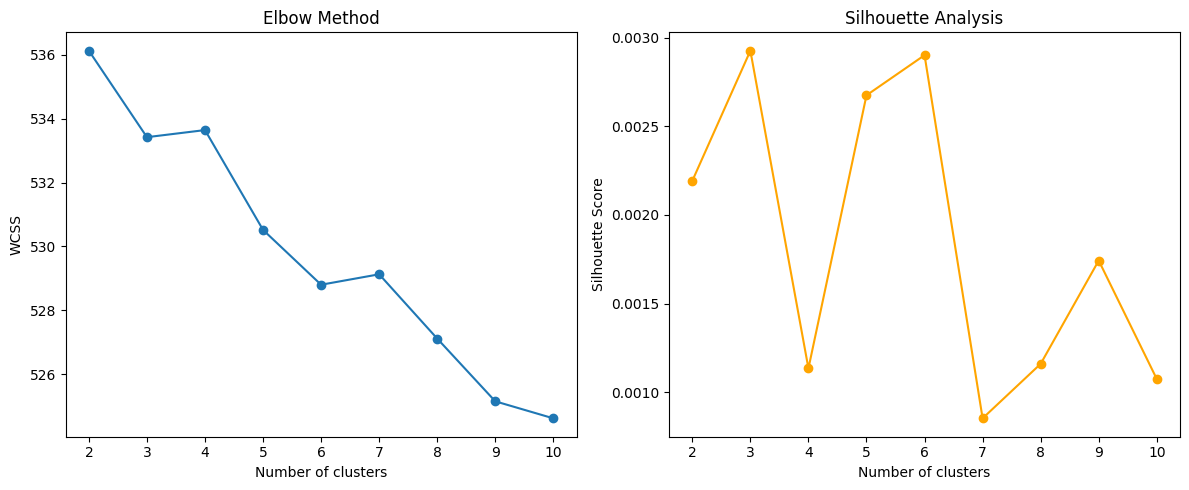

Optimal number of clusters determined: 3

Recommended Research Papers:
      Id                                              title  \
146  155  A Hybrid Deep Learning Approach for Replay and...   
7      7  Smart Optical Sensors for Internet of Things: ...   
45    48  A Hybrid Scheduling Mechanism Based on Agent C...   
238  254  An Empirical Study Into the Success of Listed ...   
348  374  An Integrative User-Level Customized Modeling ...   

                   link  year  \
146  /document/9617591/  2021   
7    /document/9718070/  2022   
45   /document/9300134/  2020   
238  /document/8919981/  2019   
348  /document/8938776/  2019   

                                               authors  cosine_similarity  
146  ['Asmaa A. Elsaeidy', 'Abbas Jamalipour', 'Kum...           0.250157  
7    ['Lília M. S. Dias', 'João F. C. B. Ramalho', ...           0.209190  
45                    ['Sehrish Malik', 'DoHyeun Kim']           0.165419  
238  ['Pieter Hartel', 'Ivan Homoliak', 'Daniël

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# 1. Load the dataset
df = pd.read_csv("/content/drive/MyDrive/dataset/database_clean.csv")

# 2. Combine the title and abstract for a richer text representation
df['text'] = df['title'] + " " + df['abstract']

# 3. Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

# 4. Determine the optimal number of clusters using the Elbow Method and Silhouette Analysis
range_n_clusters = range(2, 11)  # Testing clusters from 2 to 10
wcss = []           # Within-Cluster Sum-of-Squares for the Elbow Method
silhouette_scores = []  # For silhouette analysis

print("Determining optimal clusters:")
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Compute the sum of squared distances to the closest cluster center (WCSS)
    wcss.append(kmeans.inertia_)

    # Compute the average silhouette score
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)

    print(f"For n_clusters = {n_clusters}: WCSS = {kmeans.inertia_:.2f}, Silhouette Score = {score:.4f}")

# Plot the Elbow Method and Silhouette Analysis results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Automatically choose the number of clusters that gives the maximum silhouette score
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print("Optimal number of clusters determined:", optimal_clusters)

# 5. Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 6. Build the recommender system based on an input query

# Define the input query string
input_string = "Smart Optical Sensors"

# Convert the query string into the same TF-IDF feature space
input_vec = vectorizer.transform([input_string])

# Predict which cluster the input query belongs to
input_cluster = kmeans.predict(input_vec)[0]

# Filter the dataset to only the papers in the same cluster
cluster_indices = np.where(df['cluster'] == input_cluster)[0]
X_cluster = X[cluster_indices]

# Compute Euclidean distances from the input query vector to each paper in the same cluster
euclidean_dists = euclidean_distances(input_vec, X_cluster).flatten()

# Select the top 5 papers with the smallest Euclidean distances
top5_indices = np.argsort(euclidean_dists)[:5]
top5_cluster_indices = cluster_indices[top5_indices]

# Extract the recommended papers from the DataFrame
recommended_papers = df.iloc[top5_cluster_indices].copy()

# Compute the cosine similarity between the input query and each recommended paper
cos_sim = cosine_similarity(input_vec, X[top5_cluster_indices]).flatten()
recommended_papers['cosine_similarity'] = cos_sim

print("\nRecommended Research Papers:")
print(recommended_papers[['Id', 'title', 'link', 'year', 'authors', 'cosine_similarity']])
